In this project, you'll be analyzing the on-time performance of buses to look for patterns and try to identify correlations to controllable or external factors.

The main variable you will be studying in this project is adherence, which compares the actual departure time to the scheduled time and is included in the ADHERENCE column. A negative adherence value means that a bus left a time point late and a positive adherence indicates that the bus left the time point early. Buses with adherence values beyond negative 6 are generally considered late and beyond positive 1 are considered early. However, there is some additional logic where the staff applies waivers to allow early departures, such as an express bus that has already picked up everyone at a park-and-ride lot and is only dropping people off at the remaining stops, and also allows for early timepoint records for all records where TRIP_EDGE = 2 (end of trip), since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. Note: When determining whether a bus is early or late, it is advised that you use the 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', and 'ADJUSTED_ONTIME_COUNT' columns in order to account for the adjustments.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import plotly.express as px

In [2]:
wego = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\wego-wheely-wonka\data\Headway Data, 8-1-2023 to 9-30-2023.csv')

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [97]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'ADH_CAT', 'HOUR', 'DAYOFWEEK'],
      dtype='object')

1. What is the overall on-time performance, and what do the overall distribution of adherence look like?

In [4]:
wego['ADHERENCE'].describe()

count    338861.000000
mean         -3.188796
std           6.898842
min        -948.533333
25%          -4.566666
50%          -2.000000
75%          -0.333333
max          88.383333
Name: ADHERENCE, dtype: float64

In [123]:
for index, row in wego.iterrows():
    if row['ADJUSTED_LATE_COUNT'] > 0:
        wego.loc[index, 'ADH_CAT'] = 'late'
    elif row['ADJUSTED_EARLY_COUNT'] > 0:
        if row['TRIP_EDGE'] == 2:
            wego.loc[index, 'ADH_CAT'] = "on time"
        else:
            wego.loc[index, 'ADH_CAT'] = 'early'
    elif row['ADJUSTED_ONTIME_COUNT'] > 0:
        wego.loc[index, 'ADH_CAT'] = 'on time'

In [124]:
wego["ADH_CAT"].value_counts()

ADH_CAT
on time    282258
late        59038
early        9033
Name: count, dtype: int64

In [125]:
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,ADH_CAT,HOUR,DAYOFWEEK
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,6.500000,NaN,on time,4,Tuesday
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,0.000000,NaN,on time,4,Tuesday
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,0.000000,NaN,on time,4,Tuesday
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,NaN,0,0.000000,NaN,on time,5,Tuesday
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,0,1,0,0.0,0,12.866666,5.0,on time,5,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,1,0,0,0.0,0,0.000000,NaN,late,22,Saturday
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,1,0,0,NaN,0,0.000000,NaN,late,22,Saturday
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0,1,0,0.0,0,0.000000,NaN,on time,22,Saturday
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,1,0,0,0.0,0,0.000000,NaN,late,22,Saturday


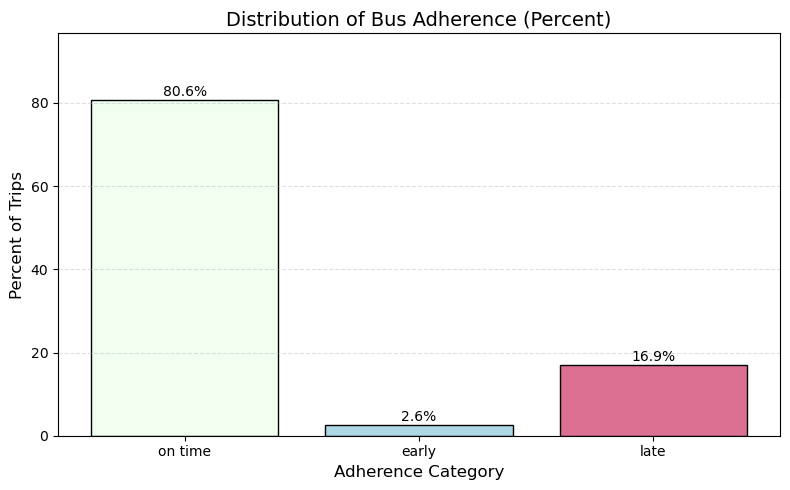

In [126]:
order = ["on time", "early", "late"]
counts = wego["ADH_CAT"].value_counts().reindex(order, fill_value=0)
total = counts.sum()
perc = (counts / total * 100).round(1)

colors = {
    "on time": "honeydew",
    "early": "lightblue",
    "late": "palevioletred"
}

plt.figure(figsize=(8, 5))
bars = plt.bar(perc.index, perc.values,
               color=[colors[c] for c in perc.index],
               edgecolor="black")

for b, p in zip(bars, perc.values):
    plt.text(b.get_x() + b.get_width()/2, p + 1, f"{p:.1f}%", ha="center", fontsize=10)

plt.title("Distribution of Bus Adherence (Percent)", fontsize=14)
plt.xlabel("Adherence Category", fontsize=12)
plt.ylabel("Percent of Trips", fontsize=12)
plt.ylim(0, max(perc.values)*1.2)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

2. How does direction of travel, route, or location affect the on-time performance?

In [104]:
route_perf = wego.groupby('ROUTE_ABBR')['ADHERENCE'].mean().sort_values()
route_perf = route_perf.to_frame()
route_perf

,ADHERENCE
ROUTE_ABBR,
55,-4.823302
52,-3.971342
3,-3.761491
7,-3.346555
56,-2.703988
50,-2.505022
23,-1.760110
22,-1.138107


In [105]:
route_perf = route_perf.reset_index()
route_perf.sort_values('ADHERENCE', ascending=False)
route_perf

,ROUTE_ABBR,ADHERENCE
0,55,-4.823302
1,52,-3.971342
2,3,-3.761491
3,7,-3.346555
4,56,-2.703988
5,50,-2.505022
6,23,-1.760110
7,22,-1.138107


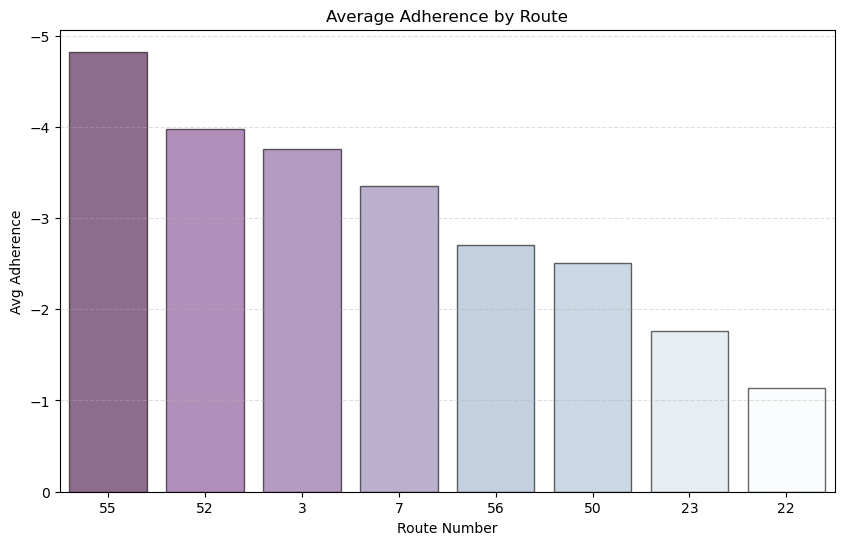

In [127]:
plt.figure(figsize=(10, 6))
sns.barplot(data=route_perf, x='ROUTE_ABBR', y='ADHERENCE', order=route_perf['ROUTE_ABBR'], edgecolor = 'black', hue = 'ADHERENCE', legend = False, palette = 'BuPu_r', alpha=0.6)
plt.title("Average Adherence by Route")
plt.ylabel("Avg Adherence")
plt.xlabel("Route Number")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.gca().invert_yaxis()
plt.show()

In [107]:
direction_perf = wego.groupby('ROUTE_DIRECTION_NAME')['ADHERENCE'].mean()
print(direction_perf)

ROUTE_DIRECTION_NAME
FROM DOWNTOWN   -3.960287
TO DOWNTOWN     -2.321804
Name: ADHERENCE, dtype: float64


In [108]:
direction_perf = direction_perf.to_frame().reset_index()
direction_perf

,ROUTE_DIRECTION_NAME,ADHERENCE
0,FROM DOWNTOWN,-3.960287
1,TO DOWNTOWN,-2.321804


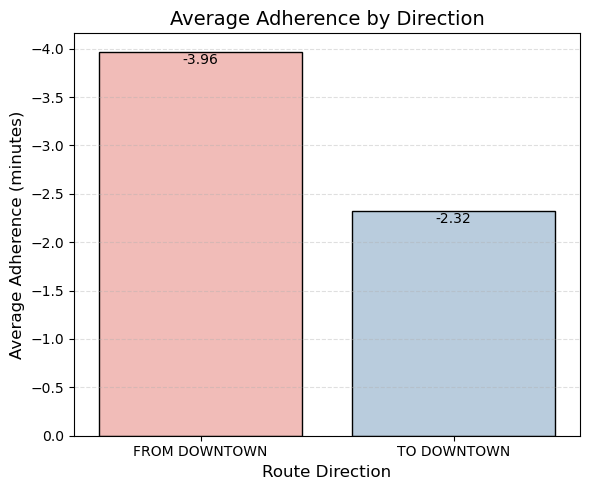

In [114]:
plt.figure(figsize=(6,5))
sns.barplot(
    data=direction_perf,
    x='ROUTE_DIRECTION_NAME',
    y='ADHERENCE',
    edgecolor='black',
    hue='ADHERENCE',
    palette='Pastel1',
    legend=False
)

plt.title("Average Adherence by Direction", fontsize=14)
plt.xlabel("Route Direction", fontsize=12)
plt.ylabel("Average Adherence (minutes)", fontsize=12)
plt.gca().invert_yaxis()  # more negative = later
plt.grid(axis='y', linestyle='--', alpha=0.4)

for i, row in enumerate(direction_perf.itertuples()):
    plt.text(i, row.ADHERENCE + 0.15, f"{row.ADHERENCE:.2f}", 
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

3. How does time of day or day of week affect on-time performance?

In [110]:
print(wego.dtypes)

CALENDAR_ID                           int64
SERVICE_ABBR                          int64
ADHERENCE_ID                          int64
DATE                                 object
ROUTE_ABBR                            int64
BLOCK_ABBR                            int64
OPERATOR                              int64
TRIP_ID                               int64
OVERLOAD_ID                           int64
ROUTE_DIRECTION_NAME                 object
TIME_POINT_ABBR                      object
ROUTE_STOP_SEQUENCE                 float64
TRIP_EDGE                             int64
LATITUDE                            float64
LONGITUDE                           float64
SCHEDULED_TIME               datetime64[ns]
ACTUAL_ARRIVAL_TIME                  object
ACTUAL_DEPARTURE_TIME                object
ADHERENCE                           float64
SCHEDULED_HDWY                      float64
ACTUAL_HDWY                         float64
HDWY_DEV                            float64
ADJUSTED_EARLY_COUNT            

In [19]:
wego['SCHEDULED_TIME'] = pd.to_datetime(wego['SCHEDULED_TIME'])

In [21]:
wego['HOUR'] = wego['SCHEDULED_TIME'].dt.hour
wego['DAYOFWEEK'] = wego['SCHEDULED_TIME'].dt.day_name()

In [28]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
wego['DAYOFWEEK'] = pd.Categorical(wego['DAYOFWEEK'], categories=order, ordered=True)

hourly = wego.groupby('HOUR')['ADHERENCE'].mean()
daily = wego.groupby('DAYOFWEEK')['ADHERENCE'].mean().sort_index()
print(hourly)
print(daily)

HOUR
0    -3.071600
1    -3.618168
4    -1.089960
5    -1.261005
6    -1.831436
7    -3.003120
8    -3.783631
9    -2.585913
10   -2.040670
11   -2.209074
12   -2.517117
13   -2.481100
14   -3.255852
15   -4.395507
16   -4.855838
17   -4.865348
18   -4.203048
19   -4.068211
20   -3.368831
21   -2.846955
22   -2.651855
23   -3.508210
Name: ADHERENCE, dtype: float64
DAYOFWEEK
Monday      -2.354027
Tuesday     -2.932405
Wednesday   -3.258849
Thursday    -3.453737
Friday      -3.829856
Saturday    -3.560335
Sunday      -2.702873
Name: ADHERENCE, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_9952\378461571.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily = wego.groupby('DAYOFWEEK')['ADHERENCE'].mean().sort_index()


In [83]:
daily_df = daily.to_frame(name='AvgAdherence').reset_index()
daily_df

,DAYOFWEEK,AvgAdherence
0,Monday,-2.354027
1,Tuesday,-2.932405
2,Wednesday,-3.258849
3,Thursday,-3.453737
4,Friday,-3.829856
5,Saturday,-3.560335
6,Sunday,-2.702873


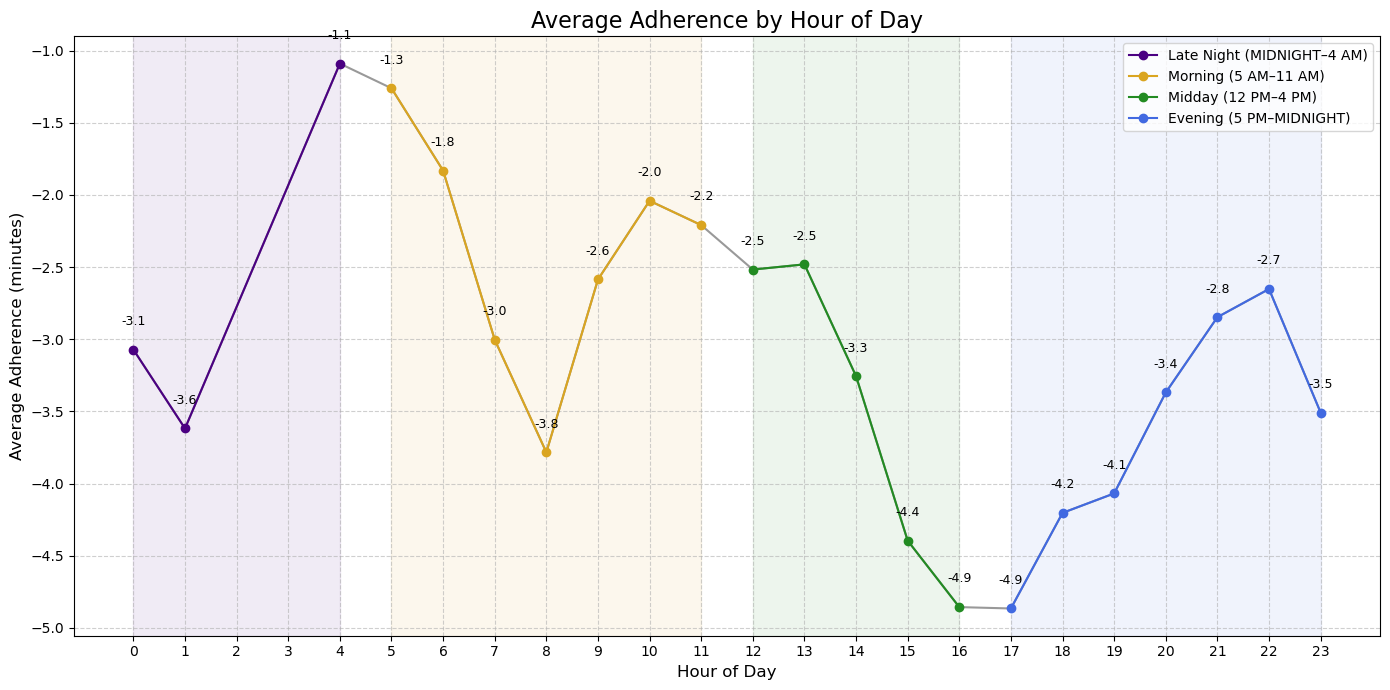

In [64]:
latenight = (hourly.index >= 0) & (hourly.index < 5)
morning = (hourly.index >= 5) & (hourly.index < 12)
midday = (hourly.index >= 12) & (hourly.index < 17)
evening = (hourly.index >= 17) & (hourly.index < 24)

plt.figure(figsize=(14,7))
plt.plot(hourly.index, hourly.values, color='black', alpha=0.4, linewidth=1.5)

plt.plot(hourly.index[latenight], hourly.values[latenight], color='indigo', marker='o', label='Late Night (MIDNIGHT–4 AM)')
plt.plot(hourly.index[morning], hourly.values[morning], color='goldenrod', marker='o', label='Morning (5 AM–11 AM)')
plt.plot(hourly.index[midday], hourly.values[midday], color='forestgreen', marker='o', label='Midday (12 PM–4 PM)')
plt.plot(hourly.index[evening], hourly.values[evening], color='royalblue', marker='o', label='Evening (5 PM–MIDNIGHT)')

plt.title("Average Adherence by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Adherence (minutes)", fontsize=12)
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.axvspan(0, 4,  color='indigo',     alpha=0.08)
plt.axvspan(5, 11, color='goldenrod',  alpha=0.08)
plt.axvspan(12,16, color='forestgreen',alpha=0.08)
plt.axvspan(17,23, color='royalblue',  alpha=0.08)

for x, y in zip(hourly.index, hourly.values):
    plt.text(x, y + 0.15, f"{y:.1f}", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

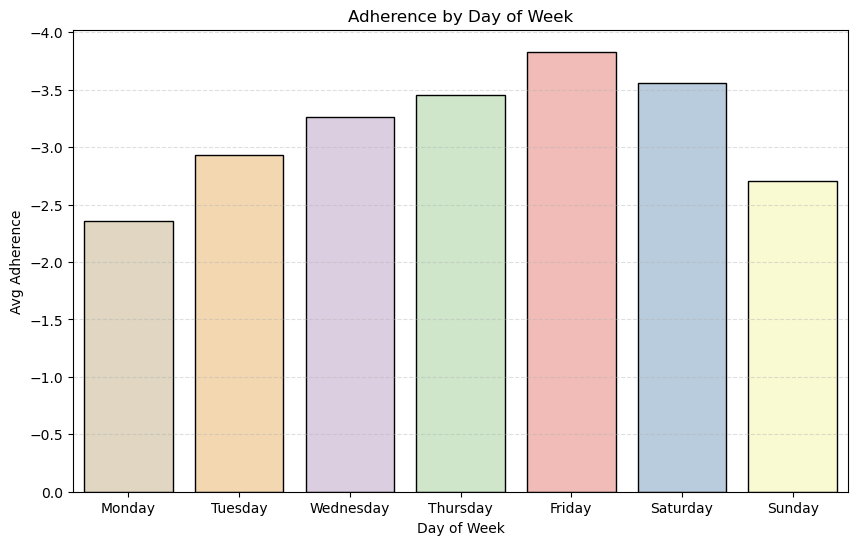

In [111]:
plt.figure(figsize=(10, 6))
sns.barplot(data=daily_df, x='DAYOFWEEK', y='AvgAdherence', order=daily_df['DAYOFWEEK'], edgecolor = 'black', hue = 'AvgAdherence', legend = False, palette = 'Pastel1')
plt.ylabel("Avg Adherence")
plt.xlabel("Day of Week")
plt.title("Adherence by Day of Week")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.gca().invert_yaxis()
plt.show()

4. How much of a factor does the driver have on on-time performance? The driver is indicated by the OPERATOR variable.

In [181]:
wego_early = wego[wego['ADH_CAT'] == 'early']
wego_late = wego[wego['ADH_CAT'] == 'late']
wego_ontime = wego[wego['ADH_CAT'] == 'on time']

In [182]:
early_top10 = (
    wego_early[wego_early['OPERATOR'] != 0]
    .groupby('OPERATOR')['ADHERENCE']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

late_top10 = (
    wego_late[wego_late['OPERATOR'] != 0]
    .groupby('OPERATOR')['ADHERENCE']
    .mean()
    .sort_values(ascending=True)
    .head(10)
)

ontime_top10 = (
    wego_ontime[wego_ontime['OPERATOR'] != 0]
    .groupby('OPERATOR')['ADHERENCE']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

In [191]:
early_top10 = early_top10.to_frame(name='AvgAdherence').reset_index()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [192]:
early_top10

,OPERATOR,AvgAdherence
0,3144,32.489697
1,1601,22.858333
2,1880,18.000000
3,2646,17.896666
4,2584,16.416666
5,3088,12.349999
6,1762,10.200000
7,3103,9.241667
8,2094,7.400000
9,2642,7.398148


In [194]:
late_top10 = late_top10.to_frame(name='AvgAdherence').reset_index()
late_top10

,OPERATOR,AvgAdherence
0,1603,-52.814062
1,2530,-45.015972
2,2497,-33.518421
3,1880,-32.292029
4,1762,-27.511594
5,1394,-25.021666
6,2103,-24.600000
7,473,-22.066666
8,1743,-21.268579
9,1542,-19.505878


In [193]:
ontime_top10 = ontime_top10.to_frame(name='AvgAdherence').reset_index()
ontime_top10

,OPERATOR,AvgAdherence
0,1762,1.392618
1,1761,1.391019
2,2435,1.184615
3,1606,0.980769
4,2103,0.674318
5,2639,0.580363
6,1730,0.554782
7,1170,0.529384
8,2432,0.468996
9,2563,0.424155


In [178]:
operator_perf = (
    wego[wego['OPERATOR'] != 0]
    .groupby(['OPERATOR', 'ADH_CAT'])['ADHERENCE']
    .mean()
    .sort_values()
)

In [179]:
operator_perf = operator_perf.to_frame(name='AvgAdherence').reset_index()

In [180]:
operator_perf

,OPERATOR,ADH_CAT,AvgAdherence
0,1603,late,-52.814062
1,2530,late,-45.015972
2,2497,late,-33.518421
3,1880,late,-32.292029
4,1762,late,-27.511594
...,...,...,...
962,2646,early,17.896666
963,1880,early,18.000000
964,1601,early,22.858333
965,3144,early,32.489697


In [172]:
top10_early = (
    operator_perf[operator_perf['ADH_CAT'] == 'early']
    .nlargest(10, 'AvgAdherence')
)

top10_late = (
    operator_perf[operator_perf['ADH_CAT'] == 'late']
    .nsmallest(10, 'AvgAdherence')
)

top10_ontime = (
    operator_perf[operator_perf['ADH_CAT'] == 'on time']
    .nlargest(10, 'AvgAdherence')
)

In [174]:
top10_early

,OPERATOR,ADH_CAT,AvgAdherence
965,3144,early,32.489697
964,1601,early,22.858333
963,1880,early,18.000000
962,2646,early,17.896666
961,2584,early,16.416666
960,3088,early,12.349999
959,1762,early,10.200000
958,3103,early,9.241667
957,2094,early,7.400000
956,2642,early,7.398148


In [175]:
top10_late

,OPERATOR,ADH_CAT,AvgAdherence
0,1603,late,-52.814062
1,2530,late,-45.015972
2,2497,late,-33.518421
3,1880,late,-32.292029
4,1762,late,-27.511594
5,1394,late,-25.021666
6,2103,late,-24.600000
7,473,late,-22.066666
8,1743,late,-21.268579
9,1542,late,-19.505878


In [176]:
top10_ontime

,OPERATOR,ADH_CAT,AvgAdherence
687,1762,on time,1.392618
686,1761,on time,1.391019
673,2435,on time,1.184615
666,1606,on time,0.980769
665,2103,on time,0.674318
664,2639,on time,0.580363
663,1730,on time,0.554782
662,1170,on time,0.529384
661,2432,on time,0.468996
660,2563,on time,0.424155


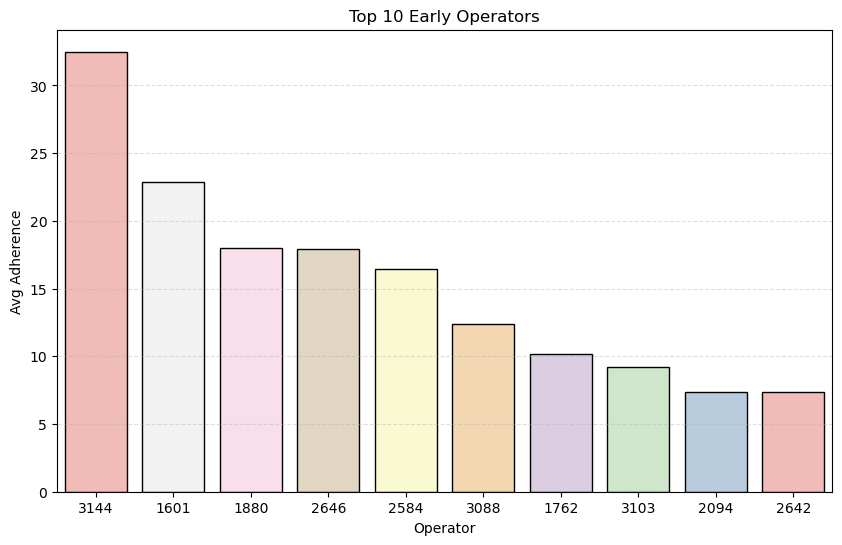

In [195]:
plt.figure(figsize=(10, 6))
sns.barplot(data=early_top10, x='OPERATOR', y='AvgAdherence', order=early_top10['OPERATOR'], edgecolor = 'black', hue = 'AvgAdherence', legend = False, palette = 'Pastel1')
plt.ylabel("Avg Adherence")
plt.xlabel("Operator")
plt.title("Top 10 Early Operators")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

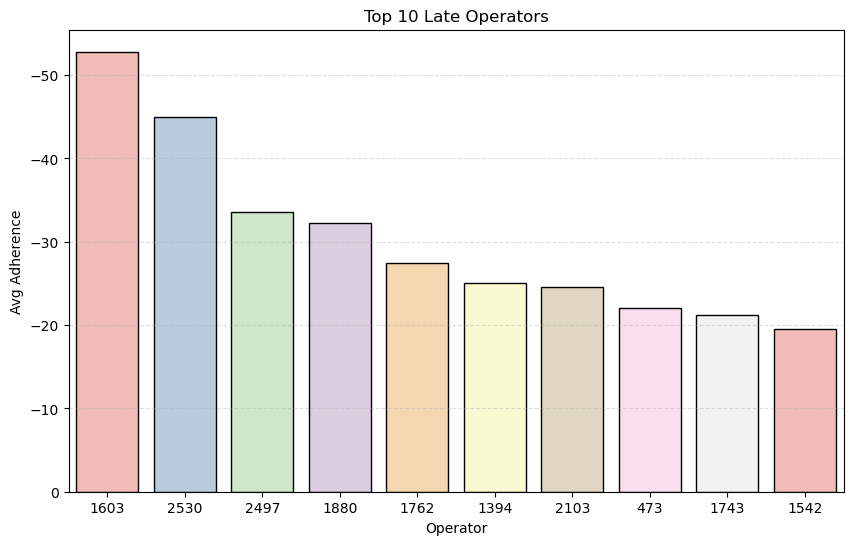

In [196]:
plt.figure(figsize=(10, 6))
sns.barplot(data=late_top10, x='OPERATOR', y='AvgAdherence', order=late_top10['OPERATOR'], edgecolor = 'black', hue = 'AvgAdherence', legend = False, palette = 'Pastel1')
plt.ylabel("Avg Adherence")
plt.xlabel("Operator")
plt.title("Top 10 Late Operators")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.gca().invert_yaxis()
plt.show()

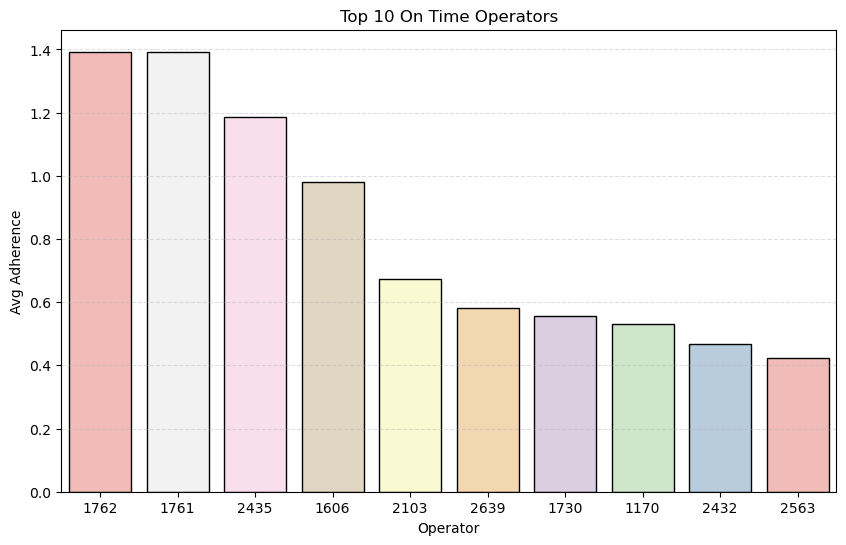

In [198]:
plt.figure(figsize=(10, 6))
sns.barplot(data=ontime_top10, x='OPERATOR', y='AvgAdherence', order=ontime_top10['OPERATOR'], edgecolor = 'black', hue = 'AvgAdherence', legend = False, palette = 'Pastel1')
plt.ylabel("Avg Adherence")
plt.xlabel("Operator")
plt.title("Top 10 On Time Operators")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

5. Is there any relationship between lateness (ADHERENCE) and headway deviation? The headway deviation variable is contained in the HDWY_DEV column. See the notes under number 9 for a description of headway and headway deviation.

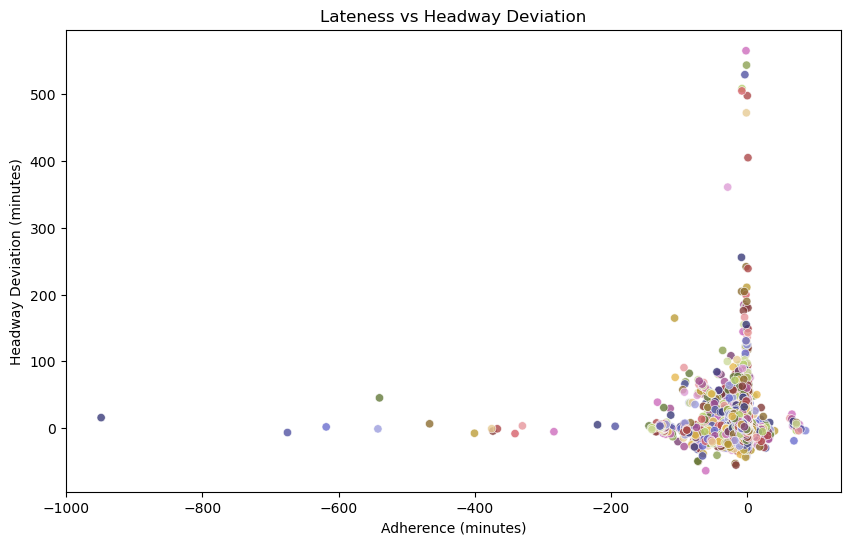

In [95]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ADHERENCE', y='HDWY_DEV', data=wego, hue='ADHERENCE', alpha=0.8, palette='tab20b', legend=False)
plt.xlabel("Adherence (minutes)")
plt.ylabel("Headway Deviation (minutes)")
plt.title("Lateness vs Headway Deviation")
plt.show()

In [44]:
correlation = wego['ADHERENCE'].corr(wego['HDWY_DEV'])
print(f"Correlation: {correlation:.2f}")

Correlation: -0.21


STRETCH GOALS

9. HDWY_DEV study

In [156]:
wego['HDWY_DEV_PCT'] = np.where(
    wego['SCHEDULED_HDWY'] > 0,
    wego['HDWY_DEV'] / wego['SCHEDULED_HDWY'],
    np.nan
)

In [157]:
def headway_status(pct):
    if pd.isna(pct) or pct == 0 or np.isinf(pct):
        return "NA"
    elif pct < 0.5:
        return "Bunched"
    elif pct > 1.5:
        return "Gapped"
    else:
        return "Acceptable"

wego['HDWY_STATUS'] = wego['HDWY_DEV_PCT'].apply(headway_status)

In [158]:
wego['HDWY_STATUS'].value_counts(dropna=False)

HDWY_STATUS
Bunched       243076
NA             85239
Acceptable     20006
Gapped          2008
Name: count, dtype: int64

In [159]:
wego.groupby('OPERATOR')['HDWY_DEV_PCT'].mean().sort_values()

OPERATOR
656    -1.000000
2338   -0.395035
2256   -0.285000
1606   -0.231865
3127   -0.229792
          ...   
623          NaN
1377         NaN
2423         NaN
2435         NaN
3080         NaN
Name: HDWY_DEV_PCT, Length: 341, dtype: float64

In [160]:
wego.groupby('OPERATOR')['HDWY_STATUS'].value_counts(normalize=True).unstack().fillna(0)

HDWY_STATUS,Acceptable,Bunched,Gapped,NA
OPERATOR,,,,
0,0.000000,0.000000,0.000000,1.000000
56,0.000000,0.666667,0.000000,0.333333
235,0.166667,0.583333,0.000000,0.250000
244,0.160000,0.640000,0.000000,0.200000
301,0.243243,0.540541,0.027027,0.189189
...,...,...,...,...
3149,0.032609,0.565217,0.010870,0.391304
3156,0.016447,0.740132,0.000000,0.243421
3165,0.250000,0.500000,0.000000,0.250000


In [161]:
wego.groupby('ROUTE_ABBR')['HDWY_DEV_PCT'].mean().sort_values()

ROUTE_ABBR
50    0.012045
56    0.013182
7     0.021907
55    0.025342
22    0.033891
52    0.041635
23    0.054504
3     0.056278
Name: HDWY_DEV_PCT, dtype: float64

In [164]:
wego['HOUR'] = pd.to_datetime(wego['ACTUAL_DEPARTURE_TIME']).dt.hour
wego.groupby('HOUR')['HDWY_DEV_PCT'].mean()

HOUR
0.0     0.031120
1.0     0.134011
4.0    -0.034396
5.0     0.019603
6.0     0.025579
7.0     0.051673
8.0     0.020974
9.0     0.011422
10.0    0.015188
11.0    0.023421
12.0    0.022253
13.0    0.021497
14.0    0.029547
15.0    0.086423
16.0    0.052059
17.0    0.031899
18.0    0.028144
19.0    0.028757
20.0    0.026074
21.0    0.020314
22.0    0.032592
23.0    0.035878
Name: HDWY_DEV_PCT, dtype: float64